## Clasificador de razas de perros

In [32]:
from keras.applications.inception_v3 import InceptionV3
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Flatten, Dropout, Dense
from keras.layers import Dropout, Flatten, Dense
from keras.models import Sequential
from keras.utils import np_utils
from sklearn.datasets import load_files
from glob import glob
import numpy as np
import pandas as pd
import os

##### Creamos una variable que tenga nuestra dirección principal para facilitarnos el código

In [33]:
path=r"C:\Users\imaqt\Documents\Cursos\python-ml-course-master\datasets\dogImages"

##### Generamos una función "load_dataset" para cargar nuestras imágenes y generar un dataset con los nombres de las razas y sus corespondientes imágenes en forma de array.  Al tener tres conjuntos, el de entrenamiento, validación y testeo, deberemos utilizar esta función en cada uno de ellos.

In [34]:
def load_dataset(path):
    data = load_files(path)
    dog_files = np.array(data['filenames'])
    dog_targets = np_utils.to_categorical(np.array(data['target']), 133)
    return dog_files, dog_targets

In [35]:
train_files, train_targets = load_dataset(path+'\\train')
valid_files, valid_targets = load_dataset(path+'\\valid')
test_files, test_targets = load_dataset(path+'\\test')

In [36]:
dog_names = [item[20:-1] for item in sorted(glob(path+"\\train\\*\\"))]

# Estadísticas del dataset
print('Hay un total de %d razas de perros.' % len(dog_names))
print('Hay un total de %s imágenes de perros.\n' % len(np.hstack([train_files, valid_files, test_files])))
print('Hay un total de %d imágenes de entrenamiento.' % len(train_files))
print('Hay un total de %d imágenes de validación.' % len(valid_files))
print('Hay un total de %d imágenes de testeo.'% len(test_files))

Hay un total de 133 razas de perros.
Hay un total de 8351 imágenes de perros.

Hay un total de 6680 imágenes de entrenamiento.
Hay un total de 835 imágenes de validación.
Hay un total de 836 imágenes de testeo.


##### En el siguiente modulo creamos dos funciones:
* "path_to_tensor": como parámetro recibe la dirección de las imágenes, cambia la imagen con un tamaño de 224x224x3 y la carga como array. Por último añadimos una dimensión más.
* "paths_to_tensor": obtenemos una lista con todas las imágenes en formato array.

Generamos una lista con todas las imágenes en formato array de cuatro dimensiones para cada uno de los conjuntos de entrenamiento, validación y testeo.

In [37]:
from keras.preprocessing import image                  
from tqdm import tqdm
def path_to_tensor(img_path):
    img = image.load_img(img_path, target_size=(224, 224))
    x = image.img_to_array(img)
    
    return np.expand_dims(x, axis=0)

def paths_to_tensor(img_paths):
    list_of_tensors = [path_to_tensor(img_path) for img_path in tqdm(img_paths)]
    return np.vstack(list_of_tensors)

In [39]:
from PIL import ImageFile                            
ImageFile.LOAD_TRUNCATED_IMAGES = True                 
# pre-process the data for Keras
train_tensors = paths_to_tensor(train_files).astype('float32')/255
valid_tensors = paths_to_tensor(valid_files).astype('float32')/255
test_tensors = paths_to_tensor(test_files).astype('float32')/255


 72%|███████▏  | 4782/6680 [00:48<00:12, 151.09it/s]


100%|██████████| 836/836 [00:06<00:00, 137.13it/s]

### Cargamos nuestro cuello de botella, "bottleneck" 

In [40]:
bottleneck_features = np.load(path+'\\bottleneck_features\\DogXceptionData.npz')
train_Xception = bottleneck_features['train']
valid_Xception = bottleneck_features['valid']
test_Xception = bottleneck_features['test']

### creamos las ultimas capas de nuestro modelo Xception
* Una capa Global average pooling 2D que recibe como input el modelo Xception.
* Una red neuronal de 133 neuronas con una función de activación softmax para que clasifique las 133 razas de perros de nuestro dataset

In [41]:
from keras.callbacks import ModelCheckpoint
Xception_classifier = Sequential()
Xception_classifier.add(GlobalAveragePooling2D(input_shape=train_Xception.shape[1:]))
Xception_classifier.add(Dense(133, activation='softmax'))

Xception_classifier.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
global_average_pooling2d_8 ( (None, 2048)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 133)               272517    
Total params: 272,517
Trainable params: 272,517
Non-trainable params: 0
_________________________________________________________________


In [42]:
Xception_classifier.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

#### Entrenando el modelo con nuestro dataset y guardando el mejor resultado para luego testearlo

In [43]:
checkpointer = ModelCheckpoint(filepath=path+'\weights.best.Xception.hdf5',
                               verbose=1, save_best_only=True)

Xception_classifier.fit(train_Xception, train_targets,
          validation_data=(valid_Xception, valid_targets),
          epochs=20, batch_size=20, callbacks=[checkpointer], verbose=1)

Train on 6680 samples, validate on 835 samples
Epoch 1/20
6680/6680 [==============================] - ETA: 1:23 - loss: 4.9840 - accuracy: 0.0000e+ - ETA: 25s - loss: 4.7559 - accuracy: 0.0625     - ETA: 13s - loss: 4.6314 - accuracy: 0.150 - ETA: 9s - loss: 4.4588 - accuracy: 0.167 - ETA: 8s - loss: 4.2965 - accuracy: 0.19 - ETA: 7s - loss: 4.0717 - accuracy: 0.23 - ETA: 6s - loss: 3.8256 - accuracy: 0.27 - ETA: 6s - loss: 3.6344 - accuracy: 0.30 - ETA: 5s - loss: 3.4433 - accuracy: 0.33 - ETA: 5s - loss: 3.2989 - accuracy: 0.35 - ETA: 5s - loss: 3.1216 - accuracy: 0.38 - ETA: 5s - loss: 3.0112 - accuracy: 0.39 - ETA: 4s - loss: 2.9126 - accuracy: 0.40 - ETA: 4s - loss: 2.7789 - accuracy: 0.42 - ETA: 4s - loss: 2.6755 - accuracy: 0.45 - ETA: 4s - loss: 2.5821 - accuracy: 0.46 - ETA: 4s - loss: 2.5119 - accuracy: 0.47 - ETA: 4s - loss: 2.4068 - accuracy: 0.49 - ETA: 3s - loss: 2.3366 - accuracy: 0.50 - ETA: 3s - loss: 2.2605 - accuracy: 0.51 - ETA: 3s - loss: 2.1872 - accuracy: 0.53 -

6680/6680 [==============================] - ETA: 2s - loss: 0.0532 - accuracy: 1.00 - ETA: 3s - loss: 0.1391 - accuracy: 0.95 - ETA: 3s - loss: 0.1373 - accuracy: 0.95 - ETA: 3s - loss: 0.2094 - accuracy: 0.93 - ETA: 3s - loss: 0.2021 - accuracy: 0.93 - ETA: 3s - loss: 0.2154 - accuracy: 0.92 - ETA: 3s - loss: 0.2064 - accuracy: 0.93 - ETA: 3s - loss: 0.2369 - accuracy: 0.92 - ETA: 3s - loss: 0.2563 - accuracy: 0.91 - ETA: 3s - loss: 0.2592 - accuracy: 0.91 - ETA: 3s - loss: 0.2677 - accuracy: 0.91 - ETA: 2s - loss: 0.2686 - accuracy: 0.91 - ETA: 2s - loss: 0.2617 - accuracy: 0.91 - ETA: 2s - loss: 0.2606 - accuracy: 0.91 - ETA: 2s - loss: 0.2558 - accuracy: 0.91 - ETA: 2s - loss: 0.2599 - accuracy: 0.91 - ETA: 2s - loss: 0.2536 - accuracy: 0.91 - ETA: 2s - loss: 0.2449 - accuracy: 0.91 - ETA: 2s - loss: 0.2434 - accuracy: 0.91 - ETA: 2s - loss: 0.2380 - accuracy: 0.91 - ETA: 2s - loss: 0.2400 - accuracy: 0.92 - ETA: 2s - loss: 0.2400 - accuracy: 0.91 - ETA: 2s - loss: 0.2351 - accura

6680/6680 [==============================] - ETA: 3s - loss: 0.6682 - accuracy: 0.85 - ETA: 3s - loss: 0.1898 - accuracy: 0.94 - ETA: 3s - loss: 0.1375 - accuracy: 0.95 - ETA: 3s - loss: 0.1521 - accuracy: 0.95 - ETA: 3s - loss: 0.1690 - accuracy: 0.94 - ETA: 3s - loss: 0.1609 - accuracy: 0.95 - ETA: 3s - loss: 0.1556 - accuracy: 0.95 - ETA: 3s - loss: 0.1503 - accuracy: 0.95 - ETA: 3s - loss: 0.1476 - accuracy: 0.95 - ETA: 3s - loss: 0.1435 - accuracy: 0.95 - ETA: 3s - loss: 0.1385 - accuracy: 0.96 - ETA: 3s - loss: 0.1419 - accuracy: 0.95 - ETA: 3s - loss: 0.1421 - accuracy: 0.95 - ETA: 3s - loss: 0.1384 - accuracy: 0.96 - ETA: 3s - loss: 0.1334 - accuracy: 0.96 - ETA: 3s - loss: 0.1358 - accuracy: 0.95 - ETA: 3s - loss: 0.1326 - accuracy: 0.96 - ETA: 2s - loss: 0.1305 - accuracy: 0.96 - ETA: 2s - loss: 0.1270 - accuracy: 0.96 - ETA: 2s - loss: 0.1277 - accuracy: 0.96 - ETA: 2s - loss: 0.1301 - accuracy: 0.96 - ETA: 2s - loss: 0.1378 - accuracy: 0.95 - ETA: 2s - loss: 0.1353 - accura

6680/6680 [==============================] - ETA: 3s - loss: 0.0031 - accuracy: 1.00 - ETA: 4s - loss: 0.1419 - accuracy: 0.98 - ETA: 4s - loss: 0.1228 - accuracy: 0.97 - ETA: 4s - loss: 0.1335 - accuracy: 0.96 - ETA: 3s - loss: 0.1276 - accuracy: 0.96 - ETA: 3s - loss: 0.1114 - accuracy: 0.96 - ETA: 3s - loss: 0.1154 - accuracy: 0.96 - ETA: 3s - loss: 0.1044 - accuracy: 0.96 - ETA: 3s - loss: 0.1008 - accuracy: 0.96 - ETA: 3s - loss: 0.0997 - accuracy: 0.96 - ETA: 3s - loss: 0.0983 - accuracy: 0.96 - ETA: 3s - loss: 0.0950 - accuracy: 0.96 - ETA: 3s - loss: 0.1003 - accuracy: 0.96 - ETA: 3s - loss: 0.0961 - accuracy: 0.97 - ETA: 3s - loss: 0.0975 - accuracy: 0.96 - ETA: 3s - loss: 0.0964 - accuracy: 0.96 - ETA: 3s - loss: 0.0949 - accuracy: 0.97 - ETA: 3s - loss: 0.0992 - accuracy: 0.96 - ETA: 3s - loss: 0.1024 - accuracy: 0.96 - ETA: 2s - loss: 0.0987 - accuracy: 0.96 - ETA: 2s - loss: 0.1008 - accuracy: 0.96 - ETA: 2s - loss: 0.0985 - accuracy: 0.96 - ETA: 2s - loss: 0.1004 - accura

6680/6680 [==============================] - ETA: 4s - loss: 0.0655 - accuracy: 0.95 - ETA: 4s - loss: 0.0504 - accuracy: 0.98 - ETA: 4s - loss: 0.0864 - accuracy: 0.97 - ETA: 4s - loss: 0.1021 - accuracy: 0.97 - ETA: 3s - loss: 0.0921 - accuracy: 0.97 - ETA: 3s - loss: 0.0864 - accuracy: 0.97 - ETA: 3s - loss: 0.0969 - accuracy: 0.97 - ETA: 3s - loss: 0.0907 - accuracy: 0.97 - ETA: 3s - loss: 0.0877 - accuracy: 0.97 - ETA: 3s - loss: 0.0854 - accuracy: 0.97 - ETA: 3s - loss: 0.0847 - accuracy: 0.97 - ETA: 3s - loss: 0.0821 - accuracy: 0.97 - ETA: 3s - loss: 0.0761 - accuracy: 0.97 - ETA: 3s - loss: 0.0730 - accuracy: 0.97 - ETA: 3s - loss: 0.0741 - accuracy: 0.97 - ETA: 3s - loss: 0.0733 - accuracy: 0.97 - ETA: 3s - loss: 0.0744 - accuracy: 0.97 - ETA: 3s - loss: 0.0722 - accuracy: 0.97 - ETA: 3s - loss: 0.0745 - accuracy: 0.97 - ETA: 3s - loss: 0.0751 - accuracy: 0.97 - ETA: 3s - loss: 0.0736 - accuracy: 0.97 - ETA: 3s - loss: 0.0789 - accuracy: 0.97 - ETA: 3s - loss: 0.0760 - accura

In [44]:
Xception_classifier.load_weights(path+'\weights.best.Xception.hdf5')

### Calculamos la precisión de nuestro modelo 

In [45]:
Xception_predictions = [np.argmax(Xception_classifier.predict(np.expand_dims(feature, axis=0))) for feature in test_Xception]

test_accuracy = 100*np.sum(np.array(Xception_predictions)==np.argmax(test_targets, axis=1))/len(Xception_predictions)
print('Test accuracy: %.4f%%' % test_accuracy)

Test accuracy: 83.4928%


In [46]:
def extract_Xception(tensor):
    from keras.applications.xception import Xception, preprocess_input
    return Xception(weights='imagenet', include_top=False).predict(preprocess_input(tensor))

#### Extraemos el cuello de botella, obtenemos un tensor con la imagen recibida en 4D, 1x224x224x3 y devolvemos la raza del perro


In [47]:

def Xception_predict_breed(img_path):
    # extract bottleneck features
    bottleneck_feature = extract_Xception(path_to_tensor(img_path))
    # obtain predicted vector
    predicted_vector = Xception_classifier.predict(bottleneck_feature)
    # return dog breed that is predicted by the model
    return dog_names[np.argmax(predicted_vector)]

### Mostramos la imagen con la funcion "show_image" y luego obtenemos una funcion que nos diga la raza, llamando a la funcion antes creada "Xception_predict_breed"

In [ ]:
import cv2
import matplotlib.pyplot as plt

def show_image (img_path):
    img = cv2.imread(img_path)
    # convert BGR image to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    # convert BGR image to RGB for plotting
    cv_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # display the image, along with bounding box
    plt.imshow(cv_rgb)
    plt.show()

def breed_detection (img_path):
        print (Xception_predict_breed(img_path))

In [55]:
img_path=path+"\\p4.jpg"

ents\Cursos\python-ml-course-master\datasets\dogImages\train\011.Australian_cattle_dog
None


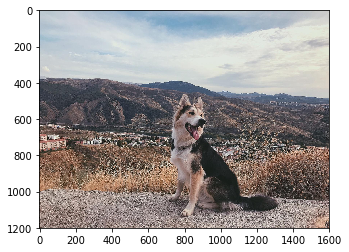


None


In [56]:
print(breed_detection(img_path))
print("\n"+str(show_image(img_path)))